Small Aircraft 
* Fixed-wing Aircraft
* Small Aircraft

Large Aircraft 
* Cargo Plane

Small Vehicle
* Passenger Vehicle
* Small Car
* Pickup Truck
* Utility Truck

Bus/Truck
* Bus
* Truck 
* Cargo Truck
* Truck w/Box
* Truck w/Flatbed
* Truck w/Liquid
* Dump Truck
* Haul Truck
* Cement Mixer
* Truck Tractor

Boat
* Motorboat
* Sailboat
* Yacht
* Maritime Vessel
* Tugboat
* Barge
* Fishing Vessel
* Ferry

New labels:

Building:
* 73:Building
* 77:Facility


In [140]:
import aug_util as aug
import wv_util as wv
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np
import csv
import tqdm
import pickle
from sklearn.model_selection import train_test_split
%matplotlib inline
import random

In [116]:
#Loading our labels
coords1, chips1, classes1 = wv.get_labels('/data/zjc4//xView_train.geojson')

100%|██████████| 601937/601937 [00:04<00:00, 143889.62it/s]


In [179]:
# Grouped classes [1,2,3,4,5]
#grouped_classes = [[11,12],[13],[17,18,20,21],\
#       [19,23,24,25,28,29,60,61,65,26],[41,42,50,40,44,45,47,49]]

grouped_classes = [[77,73],[11,12],[13],[17,18,20,21],\
       [19,23,24,25,28,29,60,61,65,26],[41,42,50,40,44,45,47,49]]

labels = ["building and facility","small aircraft",
          "large aircraft","vehicles","bus","boat"]


def transpose_class_counts(chips,classes):
    chip_names = np.unique(chips) 
    results = np.zeros((len(chip_names),len(grouped_classes)))
    chip_strs = []
    for c_idx, c in tqdm.tqdm(enumerate(chip_names)):
        chip_strs.append(c)
        classes_chip = classes[chips==c]
        idx_filter = np.isin(classes_chip,grouped_classes[0])
        # initialize to all false
        for i,gc in (enumerate(grouped_classes)):
            is_in_idxs = np.isin(classes_chip,gc)
            classes_chip[is_in_idxs] = i
            idx_filter = np.logical_or(idx_filter,is_in_idxs)
        classes_chip = classes_chip[idx_filter]
        labels, counts = np.unique(classes_chip,return_counts=True)
        for label_idx,label in enumerate(labels):
            results[int(c_idx),int(label)] = counts[label_idx]
            pass
    chip_strs_col = np.array(chip_strs).reshape(-1,1)
    return (np.hstack((chip_strs_col,results)))

def indToTifName(data, inds):
    res = []
    for ind in inds:
        res.append(data[ind][0])
    return res

def showDistribution(data, selected_indexes):
    res = []
    total = 0
    class_num = len(data[0])
    for i in range(class_num):
        for index in selected_indexes:
            total += float(data[index][i])
    for i in range(class_num):
        total_of_this_class = 0
        for index in selected_indexes:
            total_of_this_class += float(data[index][i])
        res.append(float(total_of_this_class)/total)
    return res

def showNumDistribution(data, selected_indexes):
    res = []
    total = 0
    class_num = len(data[0])
    for i in range(class_num):
        for index in selected_indexes:
            total += float(data[index][i])
    for i in range(class_num):
        total_of_this_class = 0
        for index in selected_indexes:
            total_of_this_class += float(data[index][i])
        res.append((total_of_this_class))
    return res

def checkThreshold(distr1, distr2, thres):
    if (len(distr1) != len(distr2)):
        print("columns' numbers don't fit.")
        return -1
    for i in range(len(distr1)):
        diff = abs(distr1[i] - distr2[i])
        if diff > thres:
            return False
    return True

def findBalance(data, train_percent, thres):
    tifs = len(data)
    class_num = len(data[0])
    for i in range(10000):
        tr_set, te_set = train_test_split(np.array(list(range(len(data)))),\
                                          test_size=1-train_percent)
        tr_d = showDistribution(data, tr_set)
        te_d = showDistribution(data, te_set)
        
        tr_nd = showNumDistribution(data, tr_set)
        te_nd = showNumDistribution(data, te_set)
        
        check = checkThreshold(tr_d, te_d, thres)
        if (check == -1):
            return -1
        elif (check == True):
            print("true")
            dist_results = (np.array(tr_nd).reshape(-1,1),
                            np.array(te_nd).reshape(-1,1))
            idx_results = (tr_set, te_set)
            return (dist_results,idx_results)
    return [], []

def distClassNames(dists,labels):
    labels = np.array(labels).reshape(-1,1)
    return np.hstack((labels,dists))
    pass

def splitTrainValidTest(all_chips,all_classes):
    # make the table where filename is rowwise, columns are class
    s_chips = all_chips
    s_classes = all_classes
    # Count number of classes
    results = transpose_class_counts(s_chips,s_classes)
    dists_results, idx_results = findBalance(results[:,1:], 0.8, 0.5)
    train_ind, test_ind = idx_results
    train_tifs = indToTifName(results,train_ind)
    test_tifs = indToTifName(results, test_ind)
    #return (dists_results, (train_tifs,test_tifs))

    # Split training set into train and validation
    train_tifs = indToTifName(results, train_ind)
    train_mask = np.isin(s_chips,train_tifs)
    
    # Find split for training and validation
    train_chips = s_chips[train_mask]
    train_classes = s_classes[train_mask]
    
    train_results = transpose_class_counts(train_chips,train_classes)
    train_ind, valid_ind = findBalance(train_results[:,1:], 0.7, 0.02)
    # export new train and valid tif labels
    train_tifs = indToTifName(train_results, train_ind)
    valid_tifs = indToTifName(train_results, valid_ind)
    return (train_tifs,valid_tifs, test_tifs)

    

In [162]:
idxs = range(0,100000)
dists, data_sets = splitTrainValidTest(chips1[idxs],classes1[idxs])
train_dist,test_dist = dists
print(distClassNames(train_dist,labels))
print(distClassNames(test_dist,labels))
# data_sets = splitTrainValidTest(chips1,classes1)
# how many unqiue labels are in each grouped label

123it [00:00, 196.32it/s]

true
[['building and facility' '41588.0']
 ['small aircraft' '79.0']
 ['large aircraft' '100.0']
 ['vehicles' '32635.0']
 ['bus' '4613.0']
 ['boat' '1351.0']]
[['building and facility' '6383.0']
 ['small aircraft' '0.0']
 ['large aircraft' '22.0']
 ['vehicles' '7162.0']
 ['bus' '1205.0']
 ['boat' '6.0']]


In [7]:
def countClass(classNum):
    return np.nonzero(np.isin(classes1,classNum))[0].shape

countClass(grouped_classes[1])

(316795,)

small aircraft
1810.tif


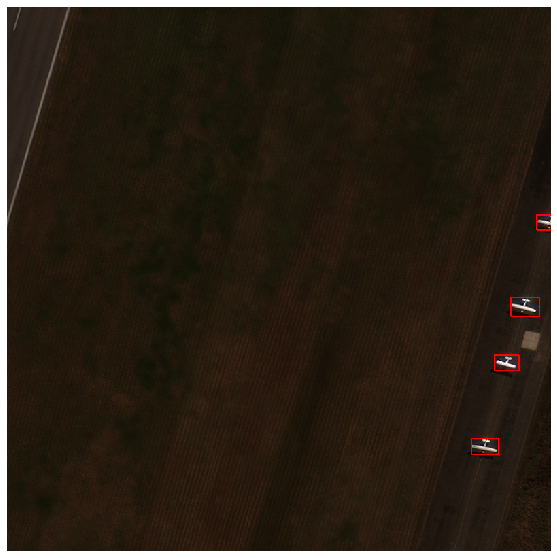

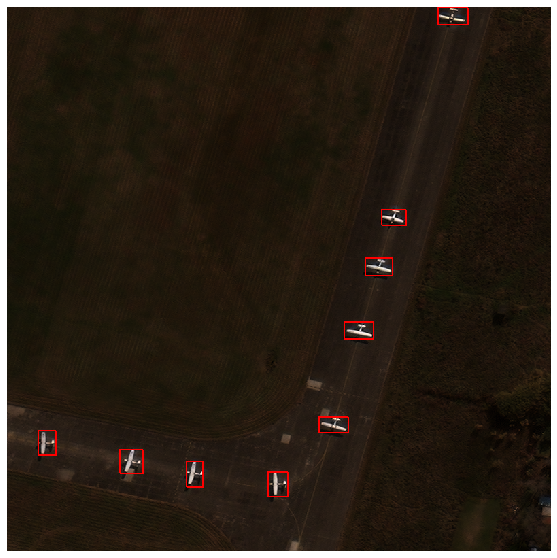

In [192]:
def showClassExample(s_class=np.array(grouped_classes[1]),
                     image_path = "/data/zjc4/train_images/",
                     chip_name=None):
    mask = (np.isin(classes1,s_class))
    schips = chips1[mask]
    if chip_name == None:
        chip_name = (np.random.choice(schips))
    print(chip_name)
    arr = wv.get_image(image_path+chip_name)
    coords = coords1[(chips1==chip_name) & (mask)]
    classes = classes1[(chips1==chip_name) & (mask)].astype(np.int64)
    c_img, c_box, c_cls = wv.chip_image(img = arr, coords= coords,
                                        classes=classes, shape=(800,800))
    for ind in range(c_img.shape[0]):
        if len(c_cls[ind]) > 2:
            labelled = aug.draw_bboxes(c_img[ind],c_box[ind])
            plt.figure(figsize=(10,10))
            plt.axis('off')
            plt.imshow(labelled)
            pass
        pass

                       
ind = 1
print(labels[ind])
showClassExample(grouped_classes[ind])#,chip_name = "1694.tif")

facility
903.tif


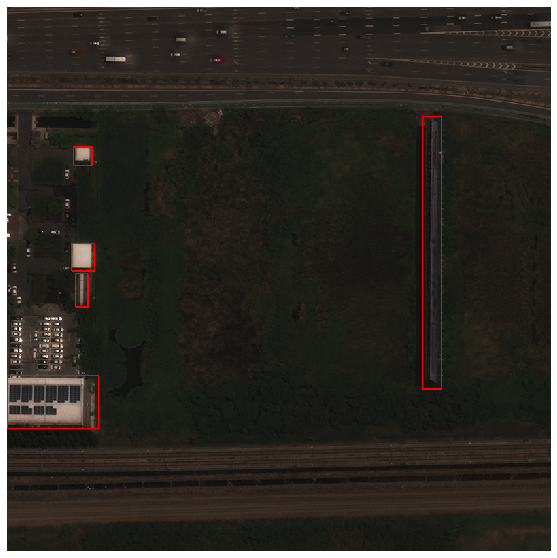

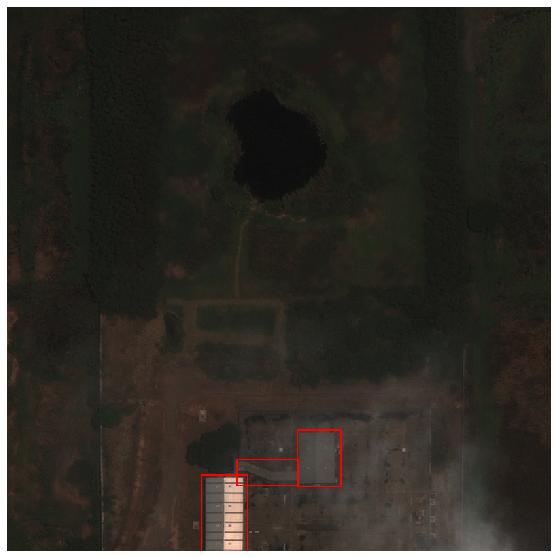

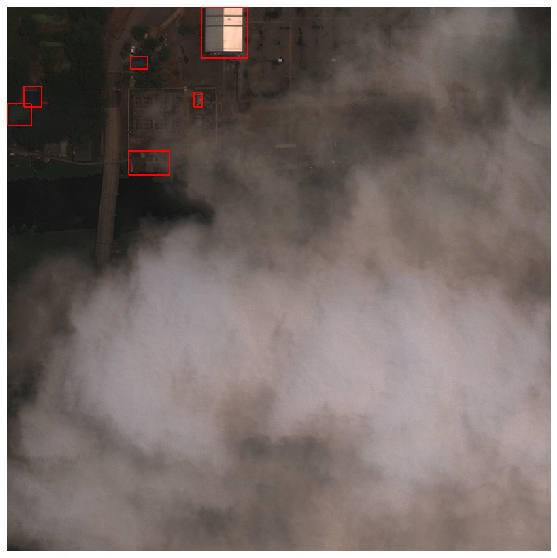

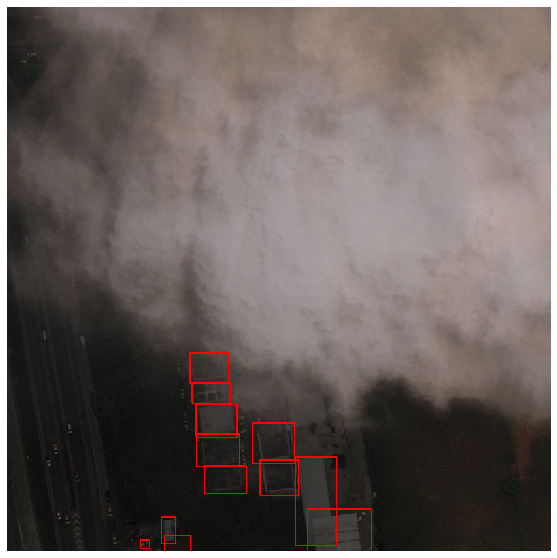

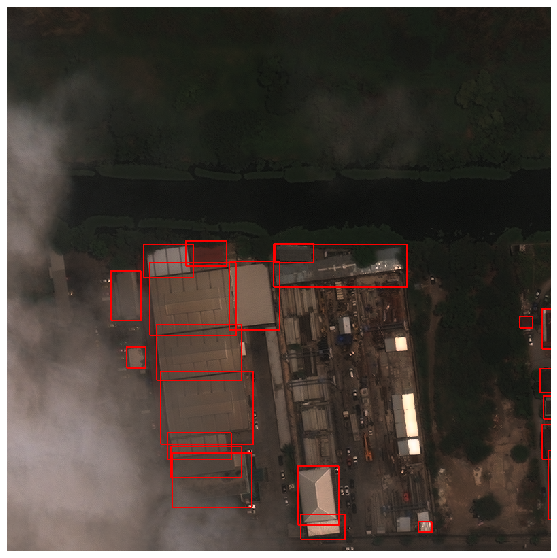

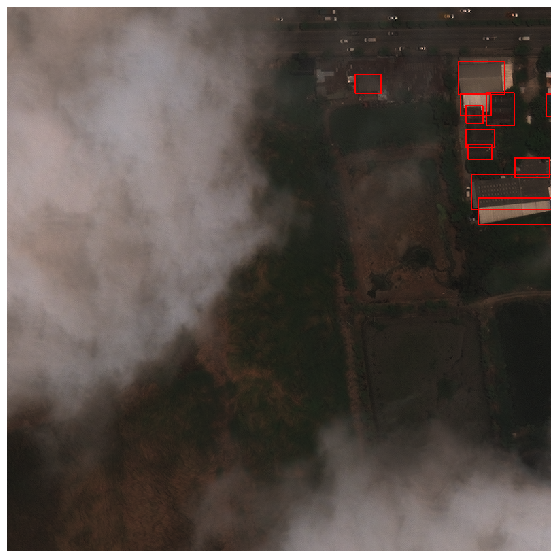

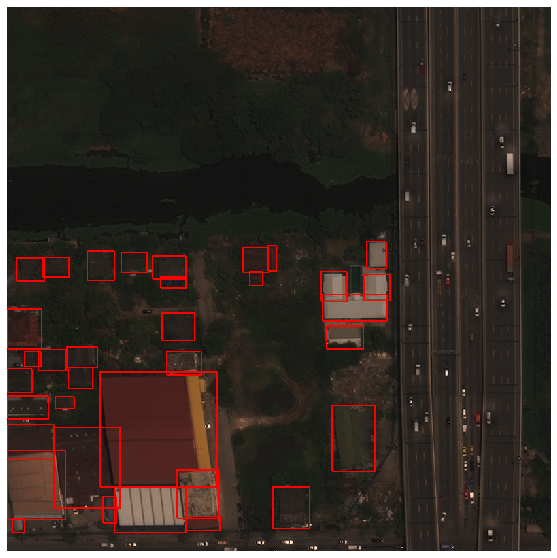

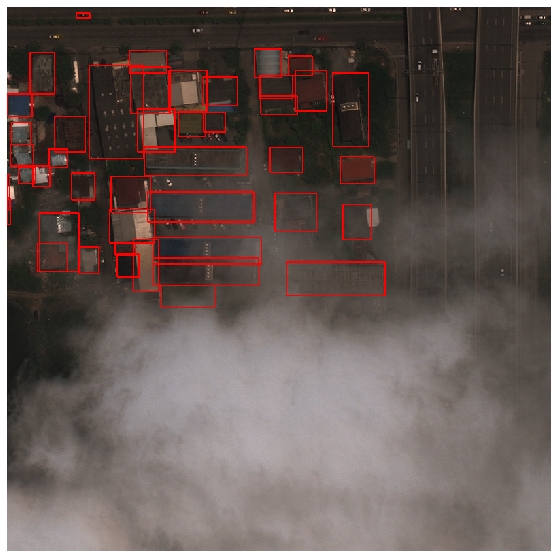

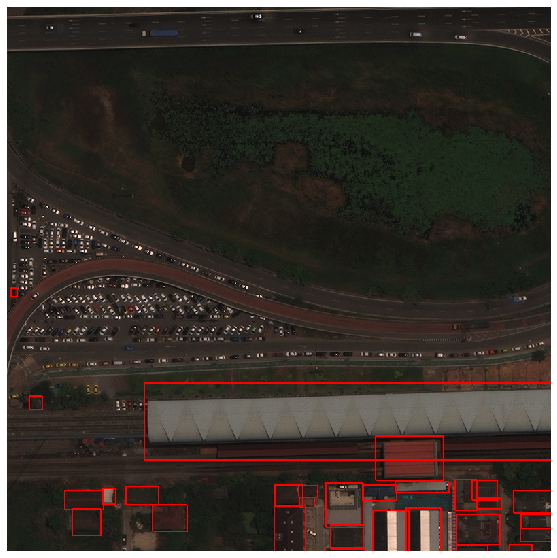

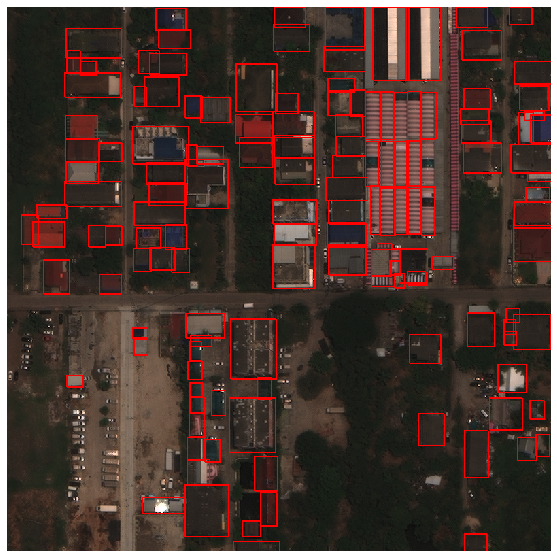

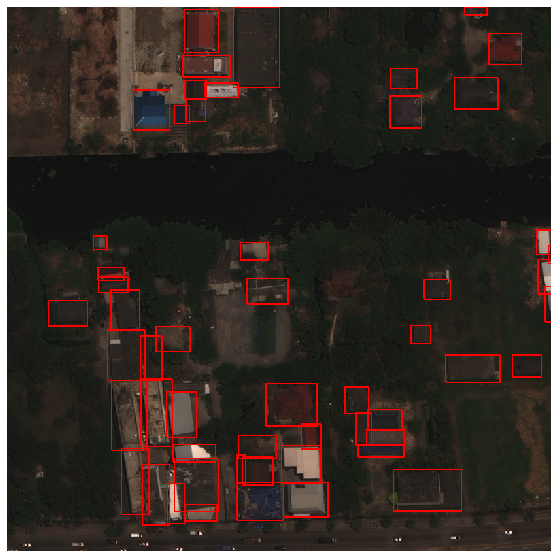

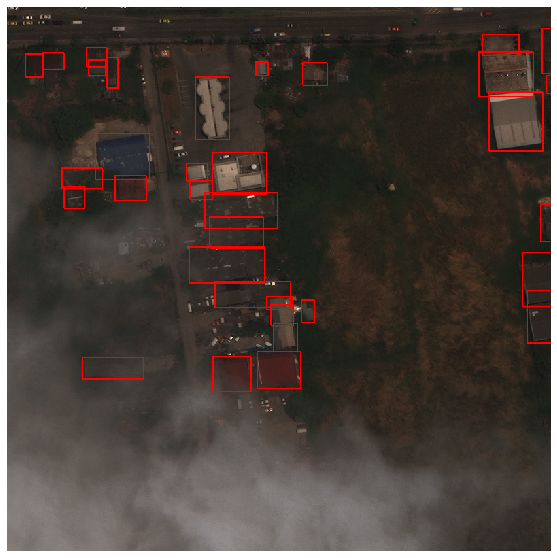

In [9]:
print(labels[2])
showClassExample(grouped_classes[1])#,chip_name = "107.tif")

# Histogram of area sizes for each label type

In [10]:
'''
calculate areas of classes
'''
xmin,ymin,xmax,ymax = coords1[:,0],coords1[:,1],coords1[:,2],coords1[:,3]
w = xmax-xmin
h = ymax-ymin
areas = (w*h )*0.3

In [11]:
# Number of labels in a class:
mask  = np.isin(classes1,grouped_classes[0])
bigBuildMask =  mask & (areas > 10000)
medBuildMask = (areas > 5000) & mask & (areas <= 10000)
smallBuildMask = (areas <= 5000) & mask 
print("number of buildings in small mask: "+str(np.sum(bigBuildMask)))

# Create new classes for big buildings and smal buildings
# create copy of arrays
classes2 = np.array(classes1,copy=True)
# big building : 1
classes2[bigBuildMask] = 1
classes2[medBuildMask] = 2
classes2[smallBuildMask] = 3
# classes2[classes1==11] = 1
# small building : 2
labels2 =["big buildings","medium buildings","small Buildings"]
grouped_classes2 = [[1],[2],[3],[11,12],[13],[17,18,20,21],\
       [19,23,24,25,28,29,60,61,65,26],[41,42,50,40,44,45,47,49]]

number of buildings in small mask: 220


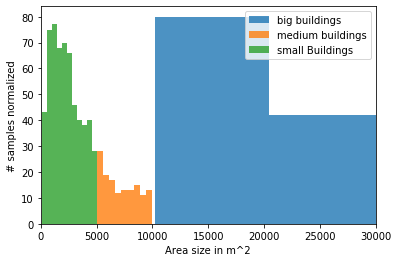

In [12]:
def plotHistogram(idx,g_cls,lbls):
    g = grouped_classes2[idx]
    mask = (np.isin(classes2,g))
    plt.hist(areas[mask],bins="auto",density=False,alpha=0.8,label=lbls[idx])
    plt.xlim(0,30000)
    #plt.title(lbls[idx])
    plt.ylabel('# samples normalized')
    plt.xlabel('Area size in m^2')
    # plt.show()
    pass

plotHistogram(0,grouped_classes2,labels2)
plotHistogram(1,grouped_classes2,labels2)
plotHistogram(2,grouped_classes2,labels2)
plt.legend()
plt.show()

In [13]:
def showClassExample(s_class=np.array(grouped_classes[1]),
                     image_path = "/data/zjc4/train_images/",
                     classes_ = classes1,
                     chip_name=None,
                     title=None):
    mask = (np.isin(classes_,s_class))
    schips = chips1[mask]
    if chip_name == None:
        chip_name = (np.random.choice(schips))
    print(chip_name)
    arr = wv.get_image(image_path+chip_name)
    coords = coords1[(chips1==chip_name) & (mask)]
    classes = classes_[(chips1==chip_name) & (mask)].astype(np.int64)
    c_img, c_box, c_cls = wv.chip_image(img = arr, coords= coords,
                                        classes=classes, shape=(800,800))
    for ind in range(c_img.shape[0]):
        if len(c_cls[ind]) > 2:
            labelled = aug.draw_bboxes(c_img[ind],c_box[ind])
            plt.figure(figsize=(10,10))
            if title != None:
                plt.title(title)
            plt.axis('off')
            plt.imshow(labelled)
            pass
        pass
    pass

ind = 2
showClassExample(grouped_classes2[ind],classes_=classes2,title=labels2[ind])

2072.tif


### Histogram of labels vs Area Sizes

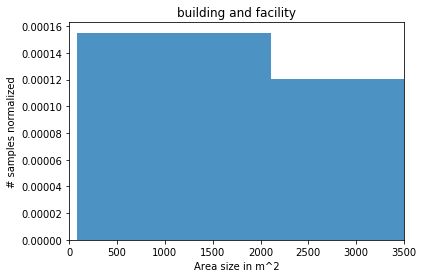

In [14]:
'''
Code for selecting one histogram
'''

idx = 0
g = grouped_classes[idx]
mask = (np.isin(classes1,g))
plt.hist(areas[mask],bins=500,density=True,alpha=0.8)
plt.xlim(0,3500)
plt.title(labels[idx])
plt.ylabel('# samples normalized')
plt.xlabel('Area size in m^2')
plt.show()

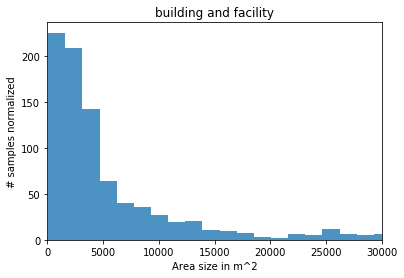

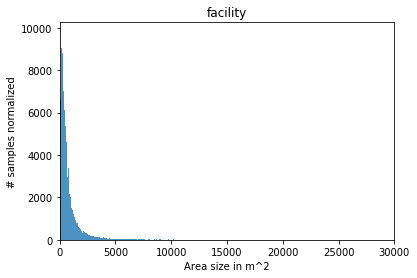

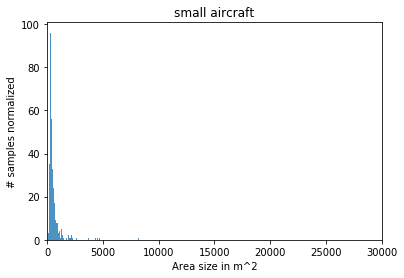

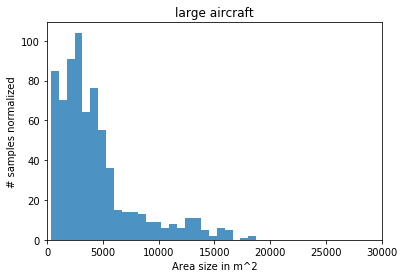

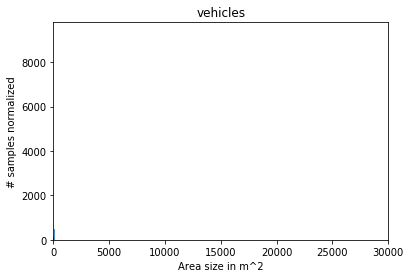

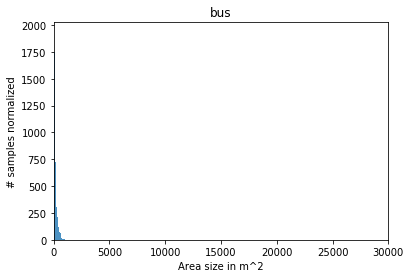

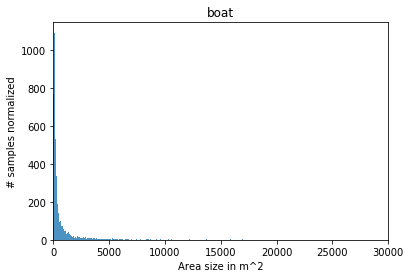

In [15]:
for idx,g in enumerate(grouped_classes):
    mask = (np.isin(classes1,g))
    plt.hist(areas[mask],bins="auto",density=False,alpha=0.8)
    plt.xlim(0,30000)
    plt.title(labels[idx])
    plt.ylabel('# samples normalized')
    plt.xlabel('Area size in m^2')
    plt.show()

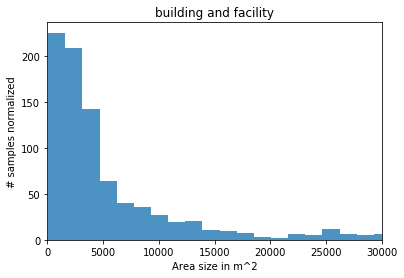

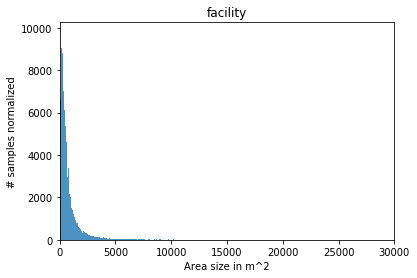

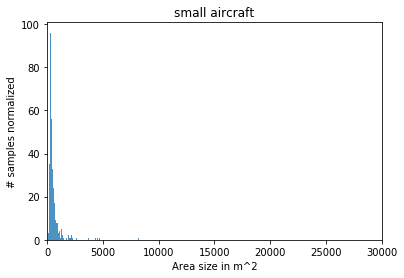

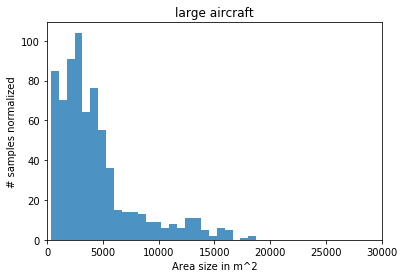

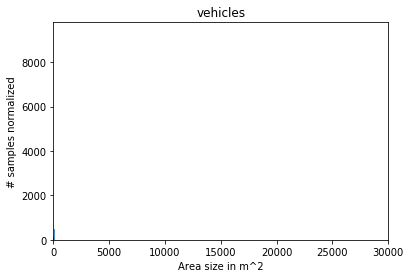

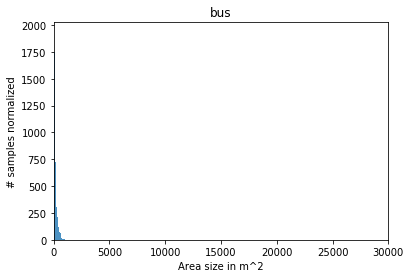

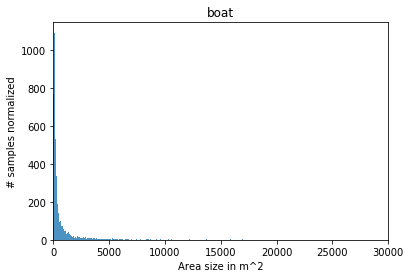

In [16]:
for idx,g in enumerate(grouped_classes):
    mask = (np.isin(classes1,g))
    plt.hist(areas[mask],bins="auto",density=False,alpha=0.8)
    plt.xlim(0,30000)
    plt.title(labels[idx])
    plt.ylabel('# samples normalized')
    plt.xlabel('Area size in m^2')
    plt.show()

In [24]:
import cv2 as cv

145.tif


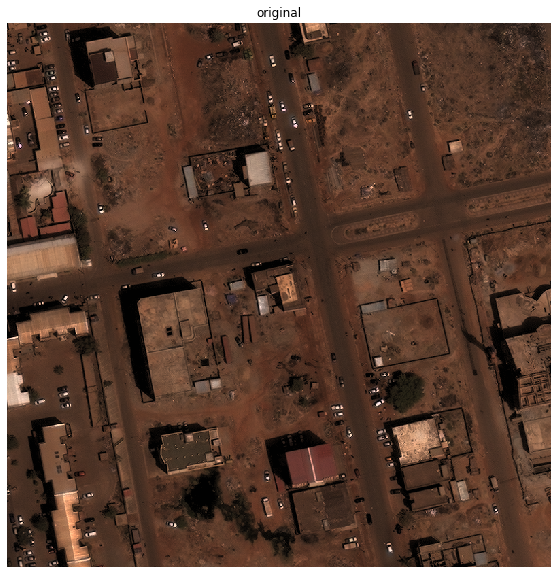

(800, 800, 3)
0.8


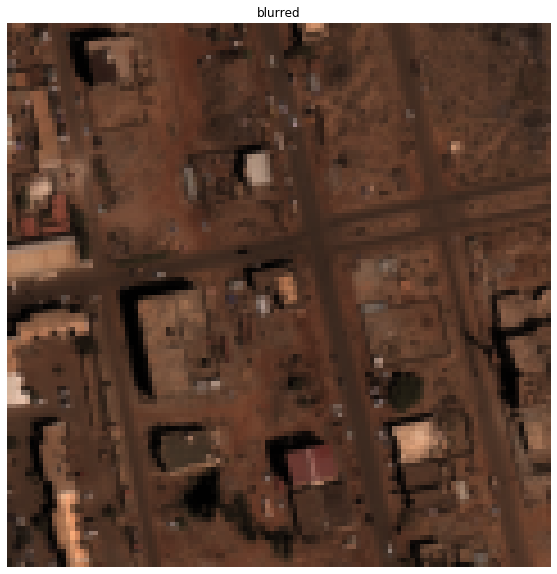

(120, 120, 3)


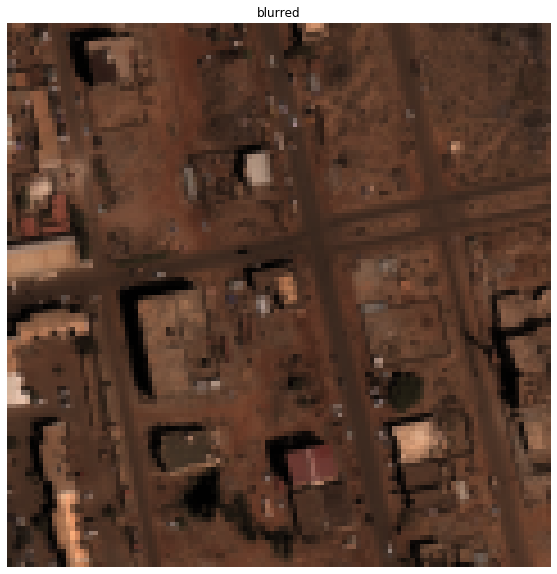

(120, 120, 3)


In [198]:
s_class=np.array(grouped_classes[1])
image_path = "/data/zjc4/train_images/"
chip_name=None

mask = (np.isin(classes1,s_class))
schips = chips1[mask]
if chip_name == None:
    chip_name = (np.random.choice(schips))
print(chip_name)
arr = wv.get_image(image_path+chip_name)
coords = coords1[(chips1==chip_name) & (mask)]
classes = classes1[(chips1==chip_name) & (mask)].astype(np.int64)
c_img, c_box, c_cls = wv.chip_image(img = arr, coords= coords,
                                    classes=classes, shape=(800,800))

res_out = 2
res_native = 0.3
img = c_img[0]
kernel_sz = int(0.5*(res_out/res_native))

scale_percent = res_native/res_out
width = int(img.shape[1] * scale_percent )
height = int(img.shape[0] * scale_percent)
dim = (width, height)

#print(cv.getGaussianKernel(ksize=5))
# print(res_out/res_native)

plt.figure(figsize=(10,10))
plt.title("original")
plt.imshow(c_img[0])
plt.axis('off')
plt.show()
print(c_img[0].shape)
sigma = 0.3*((kernel_sz-1)*0.5 - 1) + 0.8
print(sigma)
blur = cv.blur(c_img[0],(kernel_sz,kernel_sz),borderType=cv.BORDER_REFLECT)

resized = cv.resize(blur, dim, interpolation = cv.INTER_AREA)

plt.figure(figsize=(10,10))
plt.title("blurred")
plt.imshow(resized)
plt.axis('off')
plt.show()
print(resized.shape)

resized = cv.resize(c_img[0], dim, interpolation = cv.INTER_AREA)
plt.figure(figsize=(10,10))
plt.title("blurred")
plt.imshow(resized)
plt.axis('off')
plt.show()
print(resized.shape)

In [ ]:
In regards to gaussian blur